In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
!pip install meteostat
from meteostat import Point, Daily
from datetime import datetime

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gulshanroy/mechademy")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'mechademy' dataset.
Path to dataset files: /kaggle/input/mechademy


In [8]:
print("Missing values in the data DataFrame:\n", data.isnull().sum())


Missing values in the data DataFrame:
 tavg      0
tmin      0
tmax      0
prcp    367
snow    731
wdir    731
wspd      0
wpgt      0
pres      0
tsun    731
dtype: int64


In [9]:
print("Descriptive statistics for the data DataFrame:\n", data.describe())

Descriptive statistics for the data DataFrame:
             tavg      tmin       tmax      prcp  snow  wdir       wspd  \
count      731.0     731.0      731.0     364.0   0.0   0.0      731.0   
mean   12.441587  9.389603  15.647606   2.01511  <NA>  <NA>  14.744596   
std     5.381042  4.964148   6.270414  3.844465  <NA>  <NA>   5.706263   
min         -1.4      -4.0       -1.0       0.0  <NA>  <NA>        4.0   
25%          8.2       5.0       11.0       0.0  <NA>  <NA>       10.6   
50%         11.9       9.0       15.0       0.4  <NA>  <NA>       14.0   
75%         16.9      14.0       21.0       2.4  <NA>  <NA>       18.1   
max         26.8      23.0       36.0      26.0  <NA>  <NA>       38.8   

            wpgt         pres  tsun  
count      731.0        731.0   0.0  
mean   33.698085  1015.311491  <NA>  
std    11.281177     10.80668  <NA>  
min         14.8        974.5  <NA>  
25%         25.9       1008.6  <NA>  
50%         31.5       1016.5  <NA>  
75%         38.9   

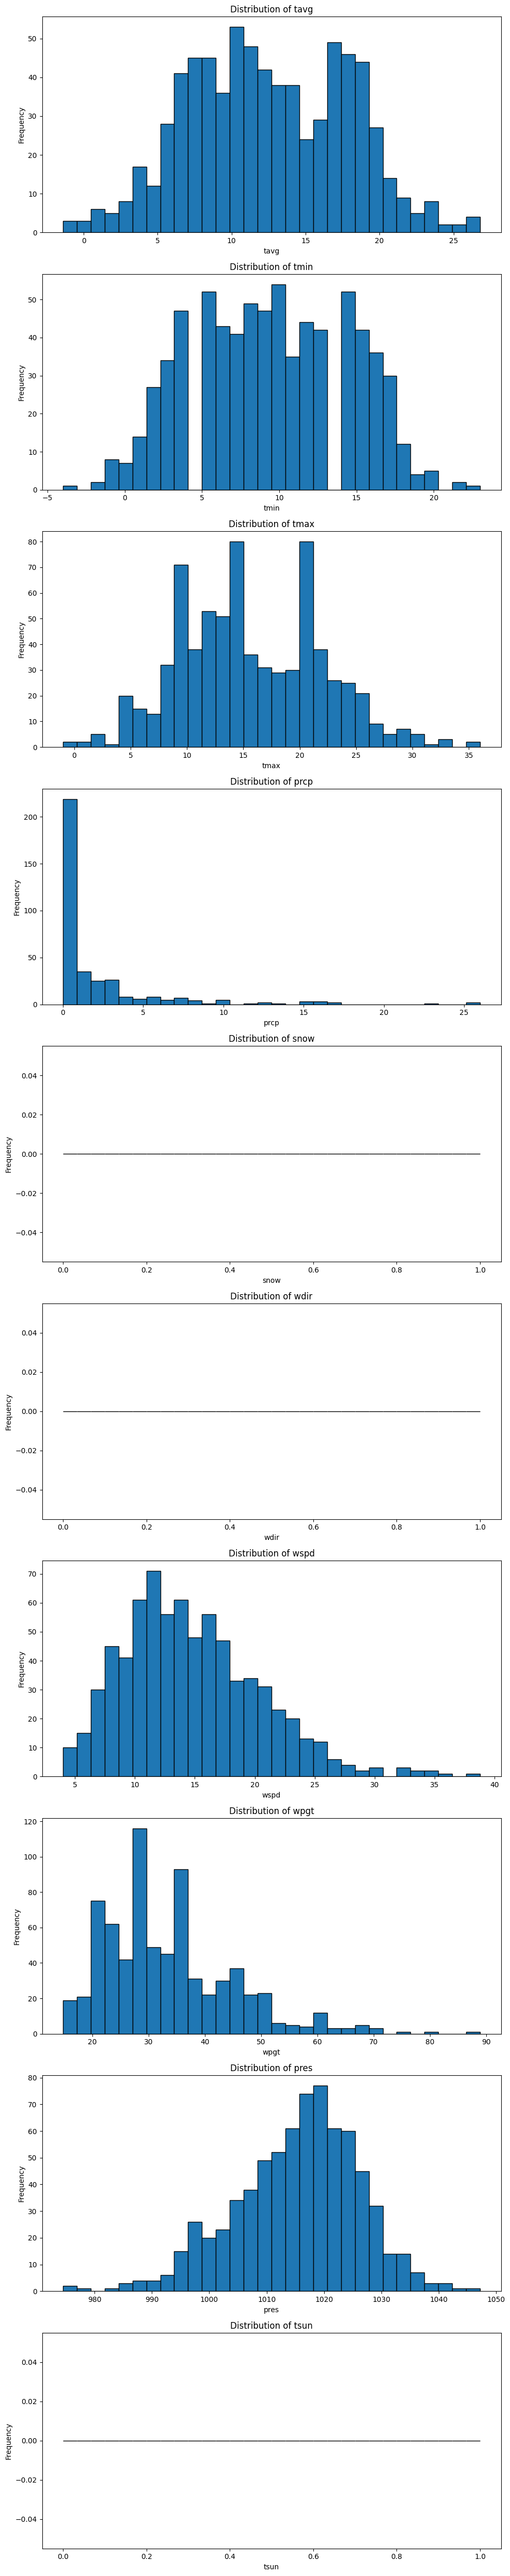

In [10]:
numerical_cols = data.select_dtypes(include=np.number).columns
fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=1, figsize=(10, 5 * len(numerical_cols)))

if len(numerical_cols) == 1:
    axes = [axes] # Ensure axes is iterable even for a single column

for i, col in enumerate(numerical_cols):
    axes[i].hist(data[col].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


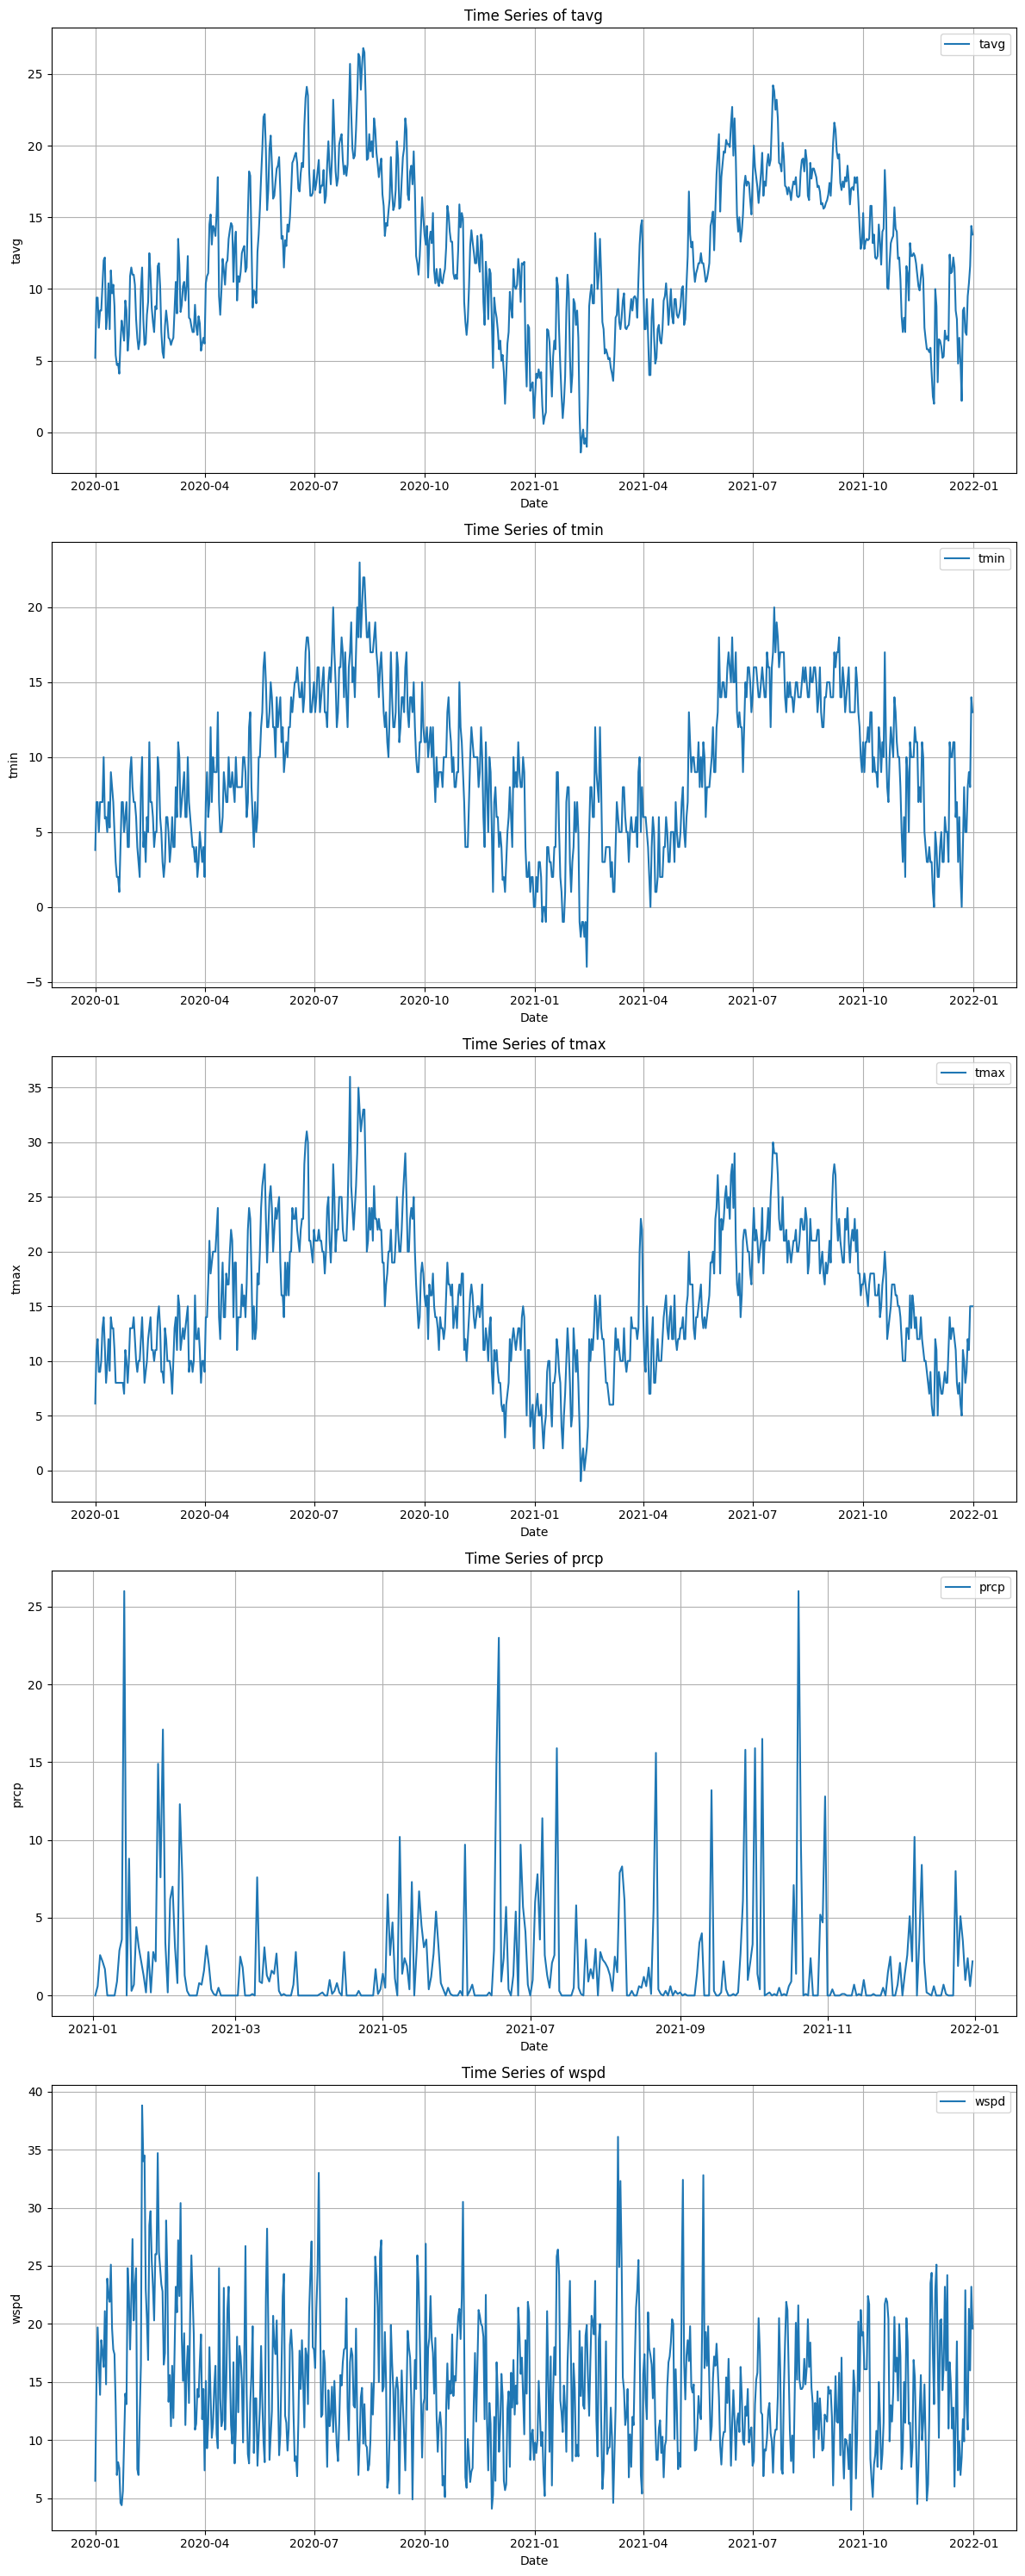

In [11]:
time_series_cols = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd']

fig, axes = plt.subplots(nrows=len(time_series_cols), ncols=1, figsize=(12, 6 * len(time_series_cols)))

if len(time_series_cols) == 1:
    axes = [axes]

for i, col in enumerate(time_series_cols):
    axes[i].plot(data.index, data[col], label=col)
    axes[i].set_title(f'Time Series of {col}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

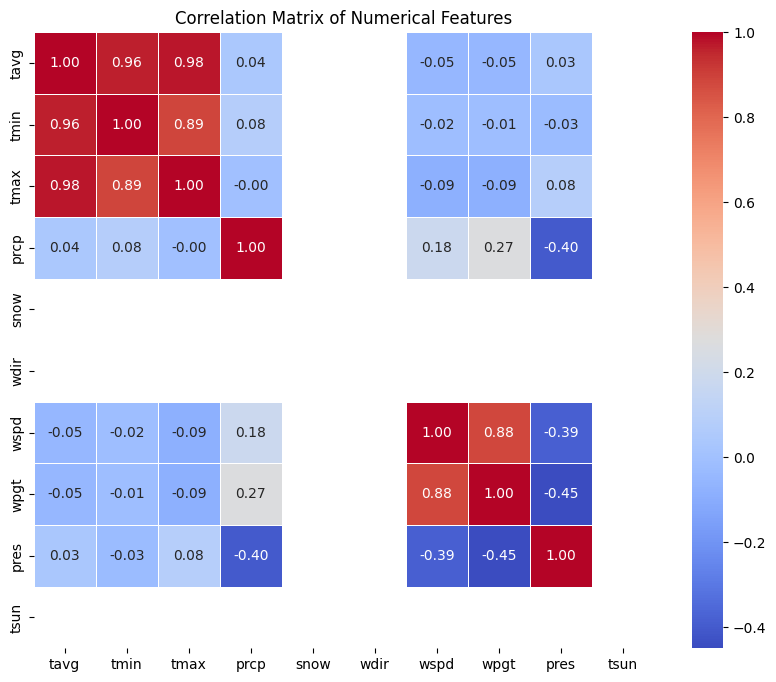

In [13]:
import seaborn as sns

numerical_data = data.select_dtypes(include=np.number)
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [14]:
if not pd.api.types.is_datetime64_any_dtype(data.index):
    data.index = pd.to_datetime(data.index)
    print("Dataframe index converted to datetime.")
else:
    print("Dataframe index is already datetime.")

Dataframe index is already datetime.


In [15]:
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['day_of_week'] = data.index.dayofweek
print("Temporal features 'year', 'month', 'day', and 'day_of_week' added to the DataFrame.")

Temporal features 'year', 'month', 'day', and 'day_of_week' added to the DataFrame.


In [16]:
lag_cols = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd']
for col in lag_cols:
    for i in range(1, 4):
        data[f'{col}_lag_{i}'] = data[col].shift(i)
print(f"Lag features created for columns: {', '.join(lag_cols)} for 1, 2, and 3 days.")

Lag features created for columns: tavg, tmin, tmax, prcp, wspd for 1, 2, and 3 days.


In [17]:
roll_cols = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd']
window_size = 7

for col in roll_cols:
    data[f'{col}_roll_mean_{window_size}d'] = data[col].rolling(window=window_size).mean()
    data[f'{col}_roll_std_{window_size}d'] = data[col].rolling(window=window_size).std()

print(f"Rolling mean and standard deviation (window size {window_size} days) created for columns: {', '.join(roll_cols)}.")

Rolling mean and standard deviation (window size 7 days) created for columns: tavg, tmin, tmax, prcp, wspd.


In [18]:
initial_rows = data.shape[0]
data.dropna(inplace=True)
final_rows = data.shape[0]
print(f"Dropped {initial_rows - final_rows} rows with NaN values. DataFrame now has {final_rows} rows.")

Dropped 731 rows with NaN values. DataFrame now has 0 rows.


In [19]:
start = datetime(2020, 1, 1)
end = datetime(2021, 12, 31)

# Define the location (London coordinates, inferred from lat/lon kernel variables)
location = Point(51.5074, 0.1278)

# Fetch daily weather data
data = Daily(location, start, end).fetch()

# Drop columns that are entirely NaN
data = data.drop(columns=['snow', 'wdir', 'tsun'])

# Re-apply feature engineering steps
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['day_of_week'] = data.index.dayofweek

lag_cols = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd']
for col in lag_cols:
    for i in range(1, 4):
        data[f'{col}_lag_{i}'] = data[col].shift(i)

roll_cols = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd']
window_size = 7

for col in roll_cols:
    data[f'{col}_roll_mean_{window_size}d'] = data[col].rolling(window=window_size).mean()
    data[f'{col}_roll_std_{window_size}d'] = data[col].rolling(window=window_size).std()

initial_rows = data.shape[0]
data.dropna(inplace=True)
final_rows = data.shape[0]

print(f"Re-initialized data, dropped fully NaN columns, applied feature engineering, and dropped {initial_rows - final_rows} rows with remaining NaN values. DataFrame now has {final_rows} rows.")

Re-initialized data, dropped fully NaN columns, applied feature engineering, and dropped 373 rows with remaining NaN values. DataFrame now has 358 rows.


In [20]:
target_column = 'tavg'
features = data.drop(columns=[target_column])
target = data[[target_column]]

print(f"Features DataFrame created with {features.shape[1]} columns.")
print(f"Target DataFrame created for '{target_column}'.")

Features DataFrame created with 35 columns.
Target DataFrame created for 'tavg'.


In [21]:
feature_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = feature_scaler.fit_transform(features)

target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target)

print("Features and target scaled using MinMaxScaler.")

Features and target scaled using MinMaxScaler.


In [22]:
look_back = 7
print(f"Look-back period defined as {look_back} days.")

Look-back period defined as 7 days.


In [24]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (280, 7, 35)
y_train shape: (280, 1)
X_test shape: (71, 7, 35)
y_test shape: (71, 1)


In [25]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

print("LSTM model architecture defined.")
model.summary()

LSTM model architecture defined.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        17,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,251 (67.39 KB)

 Trainable params: 17,251 (67.39 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

print("LSTM model compiled and trained.")

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.1157 - val_loss: 0.0815
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0316 - val_loss: 0.0137
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0196 - val_loss: 0.0302
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0127 - val_loss: 0.0154
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0139 - val_loss: 0.0223
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0113 - val_loss: 0.0166
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0112 - val_loss: 0.0199
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0104 - val_loss: 0.0168
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0109 - val_loss: 0.0186
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0102 - val_loss: 0.0167
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0090 - val_loss: 0.0159
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0086 - val_loss: 0.0179
E

In [27]:
X_flat = X.reshape(X.shape[0], -1)
y_flat = y

print(f"X_flat shape: {X_flat.shape}")
print(f"y_flat shape: {y_flat.shape}")

X_flat shape: (351, 245)
y_flat shape: (351, 1)


In [28]:
train_size = int(len(X_flat) * 0.8)
X_flat_train, X_flat_test = X_flat[0:train_size], X_flat[train_size:len(X_flat)]
y_flat_train, y_flat_test = y_flat[0:train_size], y_flat[train_size:len(y_flat)]

print(f"X_flat_train shape: {X_flat_train.shape}")
print(f"y_flat_train shape: {y_flat_train.shape}")
print(f"X_flat_test shape: {X_flat_test.shape}")
print(f"y_flat_test shape: {y_flat_test.shape}")

X_flat_train shape: (280, 245)
y_flat_train shape: (280, 1)
X_flat_test shape: (71, 245)
y_flat_test shape: (71, 1)


In [29]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

print("Required regressors imported successfully.")

Required regressors imported successfully.


In [30]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_flat_train, y_flat_train.ravel())

print("RandomForestRegressor model instantiated and trained.")

RandomForestRegressor model instantiated and trained.


In [31]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_flat_train, y_flat_train.ravel())

print("GradientBoostingRegressor model instantiated and trained.")

GradientBoostingRegressor model instantiated and trained.


In [32]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_flat_train, y_flat_train.ravel())

print("XGBRegressor model instantiated and trained.")

XGBRegressor model instantiated and trained.


In [33]:
from tensorflow.keras.layers import Dense

mlp_model = Sequential()
mlp_model.add(Dense(50, activation='relu', input_shape=(X_flat_train.shape[1],)))
mlp_model.add(Dense(1))

print("MLP model architecture defined.")
mlp_model.summary()

mlp_model.compile(optimizer='adam', loss='mean_squared_error')

mlp_history = mlp_model.fit(X_flat_train, y_flat_train, epochs=50, batch_size=32, validation_data=(X_flat_test, y_flat_test), verbose=1)

print("MLP model compiled and trained.")

MLP model architecture defined.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 50)             │        12,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,351 (48.25 KB)

 Trainable params: 12,351 (48.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.5133 - val_loss: 0.0792
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0694 - val_loss: 0.0467
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0444 - val_loss: 0.0666
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0330 - val_loss: 0.0323
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0301 - val_loss: 0.0403
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0212 - val_loss: 0.0276
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0195 - val_loss: 0.0286
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0151 - val_loss: 0.0235
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0136 - val_loss: 0.0325
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0143 - val_loss: 0.0267
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0134 - val_loss: 0.0229
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0128 - val_loss: 0.0301
E

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate LSTM Model
lstm_pred_scaled = model.predict(X_test)
lstm_pred = target_scaler.inverse_transform(lstm_pred_scaled)
actual_y_test = target_scaler.inverse_transform(y_test)

lstm_mse = mean_squared_error(actual_y_test, lstm_pred)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(actual_y_test, lstm_pred)

print("--- LSTM Model Evaluation ---")
print(f"MSE: {lstm_mse:.4f}")
print(f"RMSE: {lstm_rmse:.4f}")
print(f"MAE: {lstm_mae:.4f}")

# Evaluate RandomForestRegressor Model
rf_pred_scaled = rf_model.predict(X_flat_test)
rf_pred = target_scaler.inverse_transform(rf_pred_scaled.reshape(-1, 1))
actual_y_flat_test = target_scaler.inverse_transform(y_flat_test)

rf_mse = mean_squared_error(actual_y_flat_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(actual_y_flat_test, rf_pred)

print("\n--- RandomForestRegressor Model Evaluation ---")
print(f"MSE: {rf_mse:.4f}")
print(f"RMSE: {rf_rmse:.4f}")
print(f"MAE: {rf_mae:.4f}")

# Evaluate GradientBoostingRegressor Model
gb_pred_scaled = gb_model.predict(X_flat_test)
gb_pred = target_scaler.inverse_transform(gb_pred_scaled.reshape(-1, 1))

gb_mse = mean_squared_error(actual_y_flat_test, gb_pred)
gb_rmse = np.sqrt(gb_mse)
gb_mae = mean_absolute_error(actual_y_flat_test, gb_pred)

print("\n--- GradientBoostingRegressor Model Evaluation ---")
print(f"MSE: {gb_mse:.4f}")
print(f"RMSE: {gb_rmse:.4f}")
print(f"MAE: {gb_mae:.4f}")

# Evaluate XGBRegressor Model
xgb_pred_scaled = xgb_model.predict(X_flat_test)
xgb_pred = target_scaler.inverse_transform(xgb_pred_scaled.reshape(-1, 1))

xgb_mse = mean_squared_error(actual_y_flat_test, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(actual_y_flat_test, xgb_pred)

print("\n--- XGBRegressor Model Evaluation ---")
print(f"MSE: {xgb_mse:.4f}")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE: {xgb_mae:.4f}")

# Evaluate MLP Model
mlp_pred_scaled = mlp_model.predict(X_flat_test)
mlp_pred = target_scaler.inverse_transform(mlp_pred_scaled)

mlp_mse = mean_squared_error(actual_y_flat_test, mlp_pred)
mlp_rmse = np.sqrt(mlp_mse)
mlp_mae = mean_absolute_error(actual_y_flat_test, mlp_pred)

print("\n--- MLP Model Evaluation ---")
print(f"MSE: {mlp_mse:.4f}")
print(f"RMSE: {mlp_rmse:.4f}")
print(f"MAE: {mlp_mae:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
--- LSTM Model Evaluation ---
MSE: 10.2506
RMSE: 3.2017
MAE: 2.5530

--- RandomForestRegressor Model Evaluation ---
MSE: 7.0482
RMSE: 2.6549
MAE: 2.0351

--- GradientBoostingRegressor Model Evaluation ---
MSE: 5.7880
RMSE: 2.4058
MAE: 1.8709

--- XGBRegressor Model Evaluation ---
MSE: 8.3545
RMSE: 2.8904
MAE: 2.1435
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

--- MLP Model Evaluation ---
MSE: 14.6413
RMSE: 3.8264
MAE: 3.1287


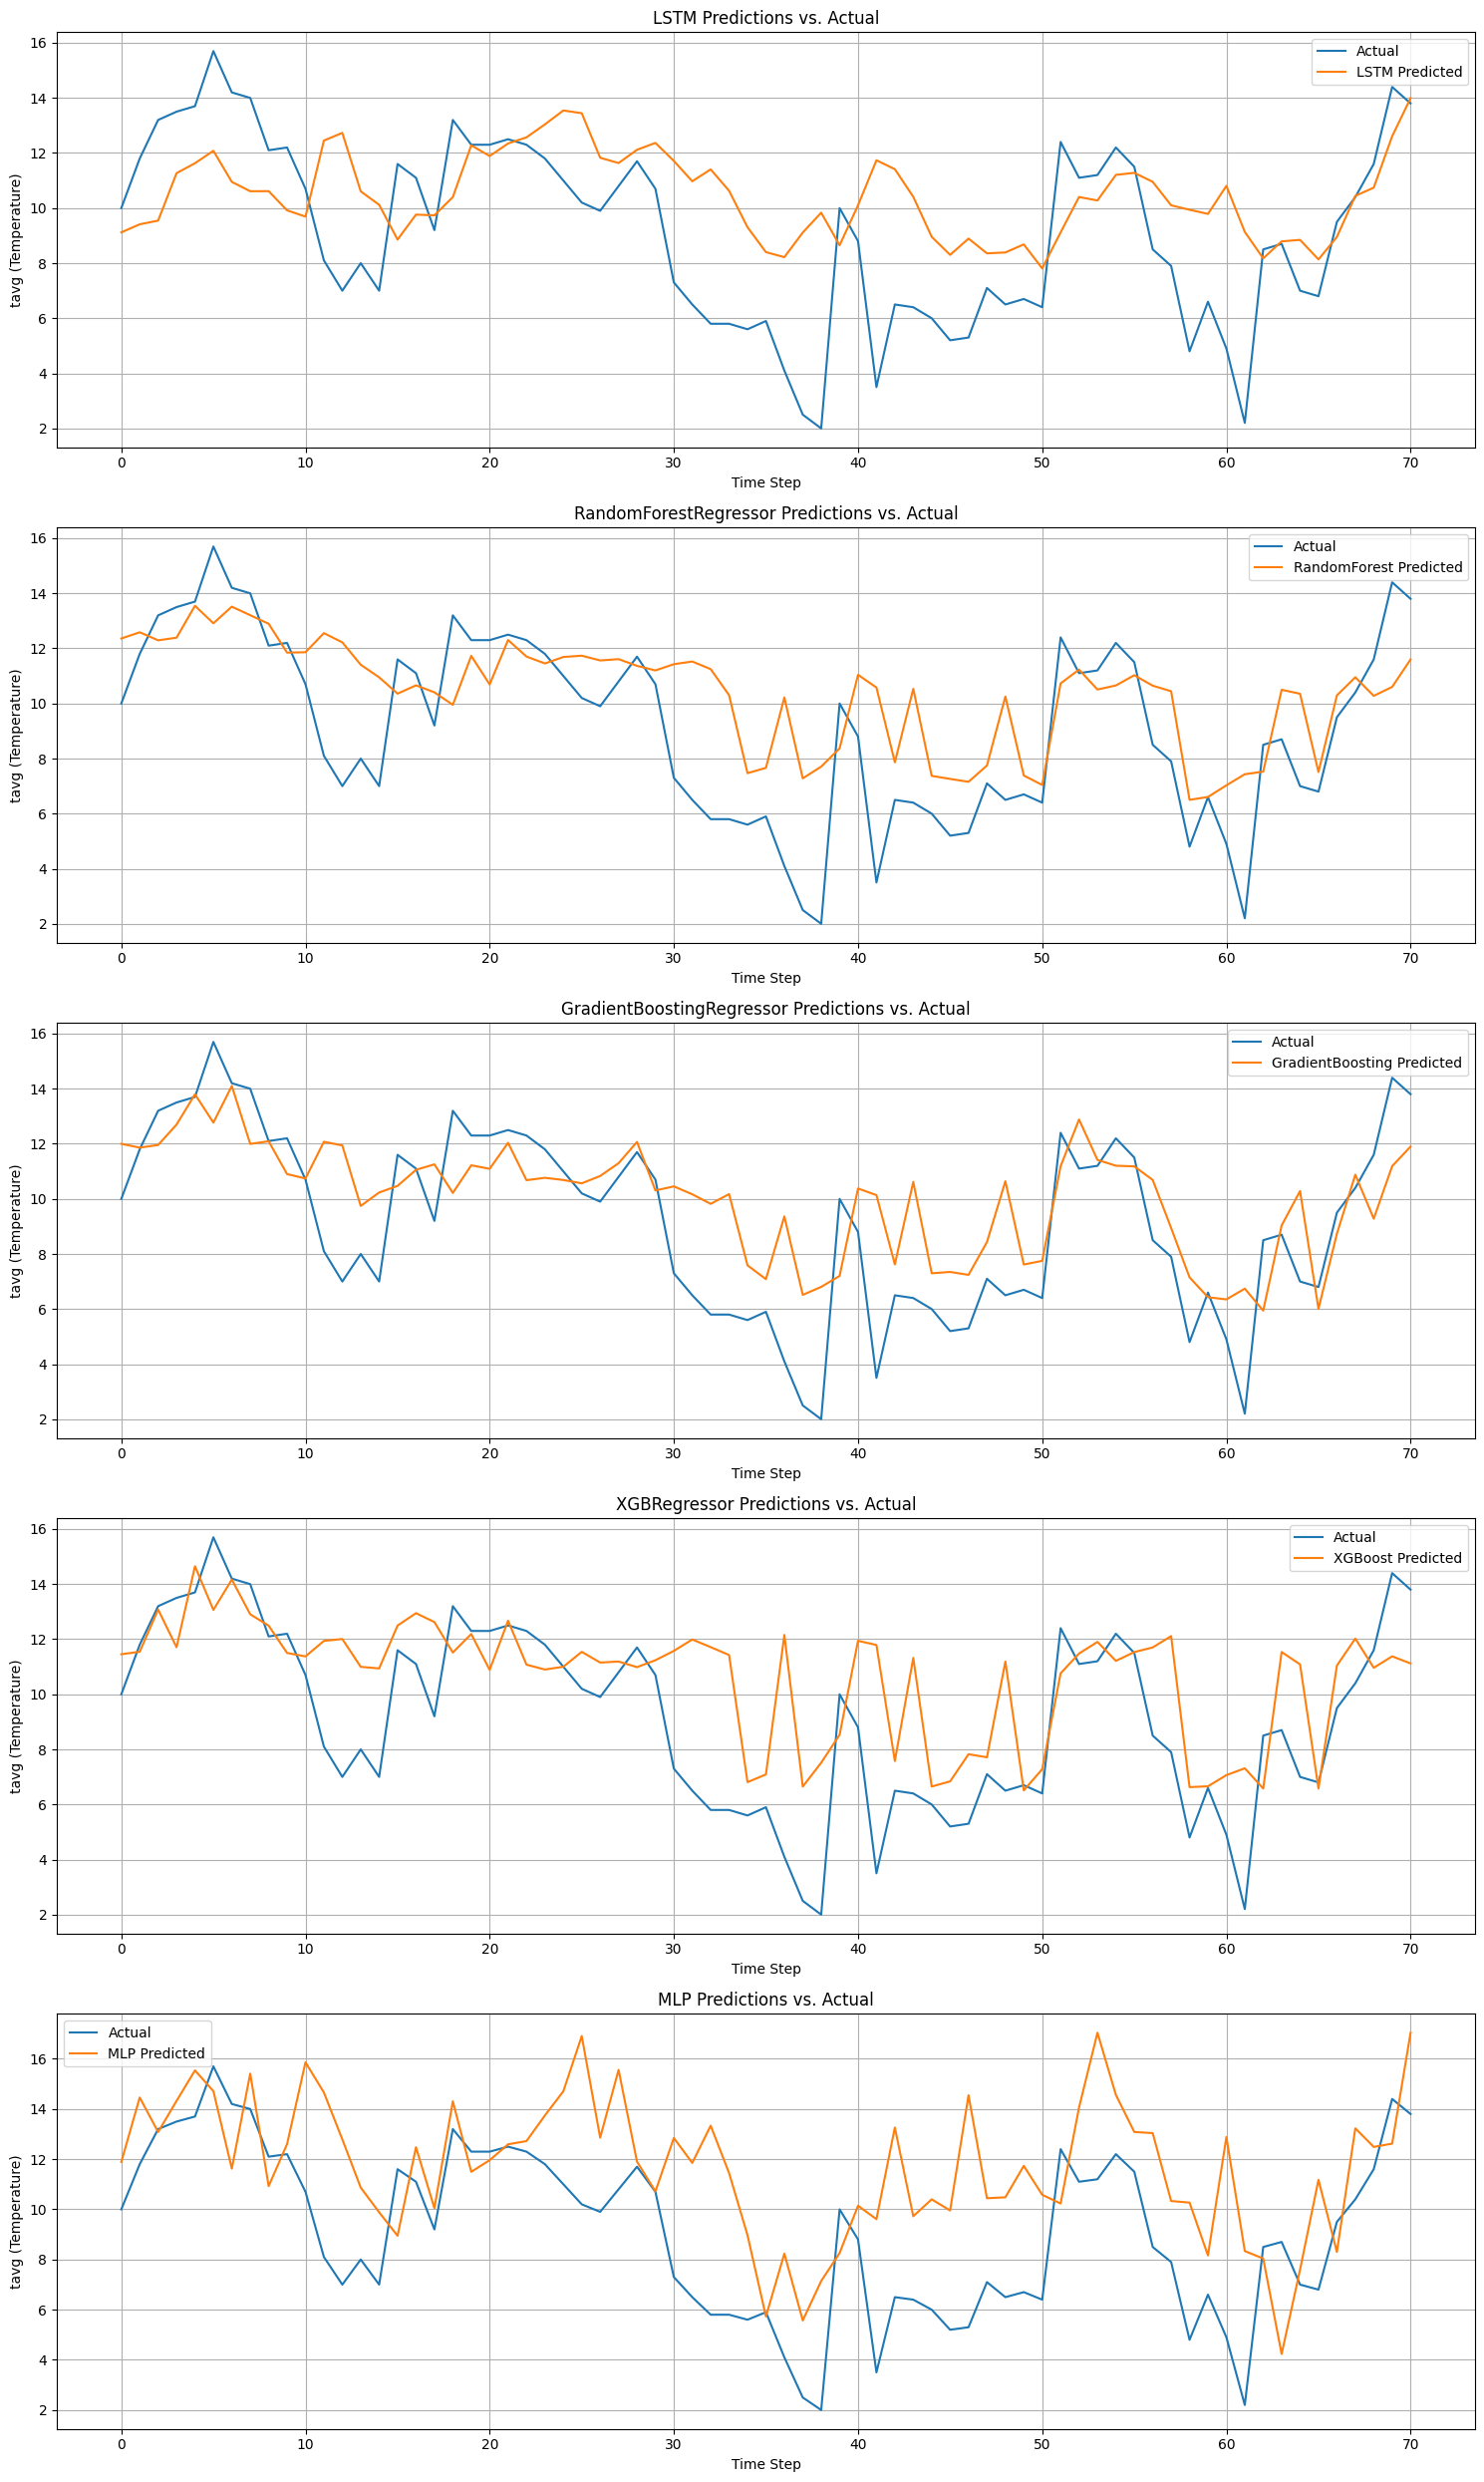

In [35]:
plt.figure(figsize=(15, 25))

# LSTM Predictions vs. Actual
plt.subplot(5, 1, 1)
plt.plot(actual_y_test, label='Actual')
plt.plot(lstm_pred, label='LSTM Predicted')
plt.title('LSTM Predictions vs. Actual')
plt.xlabel('Time Step')
plt.ylabel('tavg (Temperature)')
plt.legend()
plt.grid(True)

# RandomForestRegressor Predictions vs. Actual
plt.subplot(5, 1, 2)
plt.plot(actual_y_flat_test, label='Actual')
plt.plot(rf_pred, label='RandomForest Predicted')
plt.title('RandomForestRegressor Predictions vs. Actual')
plt.xlabel('Time Step')
plt.ylabel('tavg (Temperature)')
plt.legend()
plt.grid(True)

# GradientBoostingRegressor Predictions vs. Actual
plt.subplot(5, 1, 3)
plt.plot(actual_y_flat_test, label='Actual')
plt.plot(gb_pred, label='GradientBoosting Predicted')
plt.title('GradientBoostingRegressor Predictions vs. Actual')
plt.xlabel('Time Step')
plt.ylabel('tavg (Temperature)')
plt.legend()
plt.grid(True)

# XGBRegressor Predictions vs. Actual
plt.subplot(5, 1, 4)
plt.plot(actual_y_flat_test, label='Actual')
plt.plot(xgb_pred, label='XGBoost Predicted')
plt.title('XGBRegressor Predictions vs. Actual')
plt.xlabel('Time Step')
plt.ylabel('tavg (Temperature)')
plt.legend()
plt.grid(True)

# MLP Predictions vs. Actual
plt.subplot(5, 1, 5)
plt.plot(actual_y_flat_test, label='Actual')
plt.plot(mlp_pred, label='MLP Predicted')
plt.title('MLP Predictions vs. Actual')
plt.xlabel('Time Step')
plt.ylabel('tavg (Temperature)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [36]:
actual_y_train = target_scaler.inverse_transform(y_train)

combined_actual_y = np.concatenate((actual_y_train, actual_y_test), axis=0)

# Create the full index for the combined actual temperatures
full_index = data.index[look_back : look_back + len(X_flat)]

full_actual_tavg_series = pd.Series(combined_actual_y.flatten(), index=full_index)

# Define date ranges for plotting
train_dates_for_plot = full_index[0:train_size]
test_dates_for_plot = full_index[train_size:len(X_flat)]

print("Actual training target values inverse transformed.")
print("Combined actual temperatures series created.")
print("Train and test date ranges for plotting defined.")

Actual training target values inverse transformed.
Combined actual temperatures series created.
Train and test date ranges for plotting defined.


In [37]:
gb_pred_series = pd.Series(gb_pred.flatten(), index=test_dates_for_plot)

print("GradientBoostingRegressor prediction series created with correct dates.")

GradientBoostingRegressor prediction series created with correct dates.


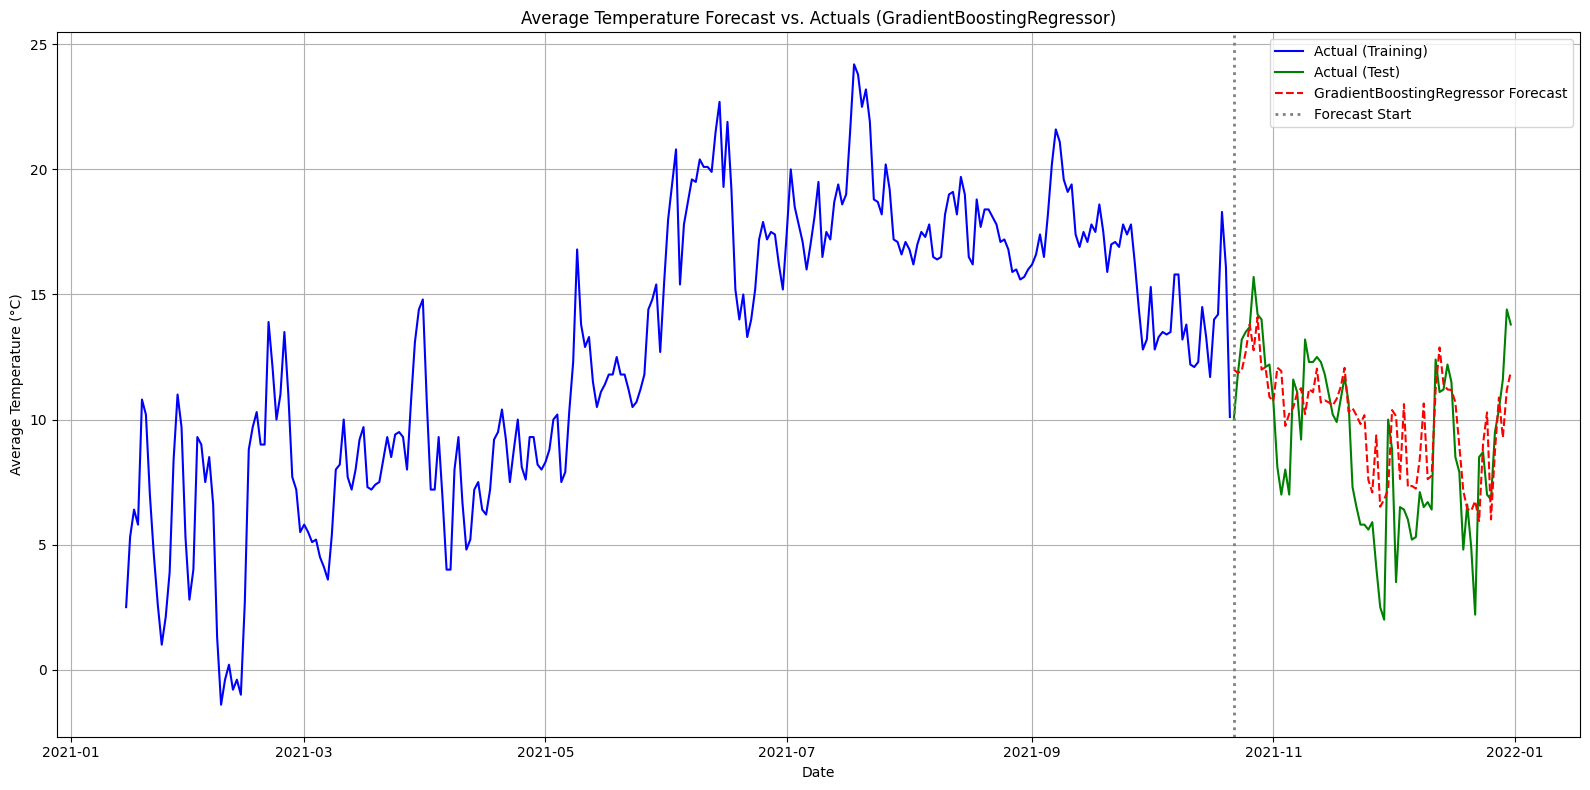

Forecast visualization plot generated.


In [38]:
plt.figure(figsize=(16, 8))

# Plot historical actuals (training period)
plt.plot(full_actual_tavg_series.loc[train_dates_for_plot], label='Actual (Training)', color='blue')

# Plot actuals for the test (forecast) period
plt.plot(full_actual_tavg_series.loc[test_dates_for_plot], label='Actual (Test)', color='green')

# Plot GradientBoostingRegressor predictions for the test period
plt.plot(gb_pred_series, label='GradientBoostingRegressor Forecast', color='red', linestyle='--')

# Delineate training and forecast periods using a vertical line
forecast_start_date = test_dates_for_plot.min()
plt.axvline(x=forecast_start_date, color='gray', linestyle=':', linewidth=2, label='Forecast Start')

plt.title('Average Temperature Forecast vs. Actuals (GradientBoostingRegressor)')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Forecast visualization plot generated.")